<a href="https://colab.research.google.com/github/JacobFV/AGI/blob/master/self_organized_criticality.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Self-Organized Criticality

In [457]:
#@title imports
%tensorflow_version 2.x

import math
import tqdm
import random

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

!pip install -q tsalib
import tsalib
import networkx
!pip install -q jplotlib
import jplotlib as jpl
!pip install -q livelossplot
from livelossplot import PlotLossesKeras

import tensorflow as tf
keras = tf.keras
tfkl = keras.layers

import tensorflow_probability as tfp
tfd = tfp.distributions
tfpl = tfp.layers
tfb = tfp.bijectors

In [406]:
#@title utils

def Bernoulli(p, shape=None):
    return tf.cast(tf.random.uniform(shape) < p, tf.float32)

def clear_diag(A):
    return A * (1 - tf.eye(tf.shape(A)[-2], tf.shape(A)[-1]))

## [Self-organized criticality in neural networks from activity-based-rewiring](https://arxiv.org/abs/2009.1178)

Let $N=( \mathbf{a}, \mathbf{\bar{a}}, C )$ be a $n$-node network where
- $\mathbf{a} = a_{1,2,\dots,n} \in [0,1]^{b \times n}$ are its node states 
- $\mathbf{\bar{a}} = \bar{a}_{1,2,\dots,n} \in [0,1]^{b \times n}$ are its mean node states 
- $C = \{c_{ij}\} \in [-1, 1]^{n \times n}$ is its connectivity matrix from node $i$ to node $j$

At every time step:
- all nodes update their state by $\mathbf{a}' \sim P(\sigma(\mathbf{a}C))$
- update mean activations $\mathbf{\bar{a}}' = \alpha \mathbf{a} + (1 - \alpha) \mathbf{\bar{a}}$
- one node $j$ is uniformly selected for presynaptic connectivity $C_{:,j}$ update by:
    - if $\bar{a_j} > +1-\epsilon$, randomly make one input $k$ negative $C_{k,j} = -1$
    - if $\bar{a_j} < -1+\epsilon$, randomly make one input $k$ positive $C_{k,j} = +1$
    - otherwise, randomly remove one input $C_{?,j} = 0$

Parameters:
- $n =$ number neurons
- $b =$ batch size
- $\beta \in (0, \infty) =$ inverse temperature. Higher values decrease entropy. 
- $P =$ the Bernoilli distribution
- $\epsilon =$ update threshold
- $\alpha \in [0, 1] =$ mean activation update window

### `update` function

In [ ]:
p = params = dict(n=32, b=1, beta=2, epsilon=0.2, alpha=0.1)

def update(inputs):
    a, a_ave, C = inputs
    
    a = tfp.distributions.Bernoulli(logits=p['beta'] * (a @ C)).sample()
    a = tf.cast(a, tf.float32)
    
    a_ave = p['alpha'] * a + (1 - p['alpha']) * a_ave
    
    js = tf.random.uniform(shape=(p['b'],), minval=0, maxval=p['n'], dtype=tf.int32) # dest nodes
    ks = tf.random.uniform(shape=(p['b'],), minval=0, maxval=p['n'], dtype=tf.int32) # src nodes
    
    for b in tf.range(p['b']):
        j = js[b]
        k = ks[b]
        
        if a_ave[b, j] > +1 - p['epsilon']:
            C[k,j].assign(-1.0)
        elif a_ave[b, j] < p['epsilon']:
            C[k,j].assign(+1.0)
        else:
            C[k,j].assign(0.0)
    
    return (a, a_ave, C)

def loop(data, duration=1000):    
    for _ in tf.range(duration):
        data = update(data)
    return data

100%|██████████| 20/20 [00:09<00:00,  2.21it/s]


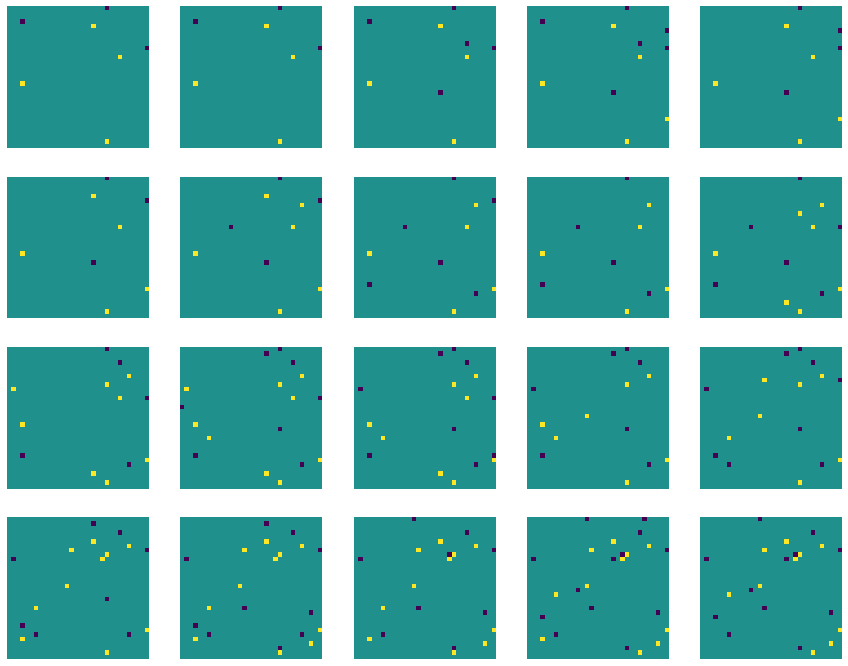

In [ ]:
a = tf.zeros((params['b'], params['n']))
a_ave = tf.zeros((params['b'], params['n']))
C = tf.zeros((params['n'], params['n']))
C = tf.Variable(C)
#C = tf.random.uniform((params['n'], params['n']), minval=-1.0, maxval=1.0)
states = (a, a_ave, C)

T_step = 100
N = 20

N_col = 5
N_row = math.ceil(N / N_col)
fig, axes = plt.subplots(nrows=N_row, ncols=N_col, figsize=(3*N_col, 3*N_row))

for n in tqdm.tqdm(range(N)):
    a, a_ave, C = loop((a, a_ave, C), duration=T_step)
    
    col = n % N_col
    row = n // N_col
    axes[row, col].axis('off')
    axes[row, col].imshow(C)
        
plt.show()

### keras layer

In [ ]:
class CriticalLayer0(tfkl.Layer):
    
    DEFAULT_PARAMS = dict(
        n=None,
        b=None,
        beta=2,
        epsilon=0.2,
        alpha=0.1,
        steps_update=10)
    
    def __init__(self, p=None, **kwargs):
        super(CriticalLayer0, self).__init__(**kwargs)
        
        if p is None:
            p = dict()
        self.p = CriticalLayer0.DEFAULT_PARAMS
        self.p.update(p)
        
    def build(self, input_shape):
        self.p['b'], self.p['n'] = input_shape.as_list()
        
        self.a_ave = tf.zeros((self.p['b'], self.p['n']), dtype=tf.float32)
        self.C = tf.random.uniform((self.p['n'], self.p['n']), dtype=tf.float32)
        self.C = tf.Variable(self.C)
        
    def call(self, inputs):
        a = inputs
        for _ in tf.range(self.p['steps_update']):
            a = self._single_update(a)
        return a

    def _single_update(self, a):
        a = self.p['beta'] * (a @ self.C)
        a = tfd.Bernoulli(logits=a).sample()
        a = tf.cast(a, tf.float32)

        self.a_ave = self.p['alpha'] * a + (1 - self.p['alpha']) * self.a_ave

        js = tf.random.uniform(shape=(self.p['b'],), 
                               minval=0, maxval=self.p['n'], 
                               dtype=tf.int32) # dest nodes
        ks = tf.random.uniform(shape=(self.p['b'],), 
                               minval=0, maxval=self.p['n'], 
                               dtype=tf.int32) # src nodes

        for b in tf.range(self.p['b']):
            j = js[b]
            k = ks[b]

            if self.a_ave[b, j] > +1 - self.p['epsilon']:
                self.C[k,j].assign(-1.0)
            elif self.a_ave[b, j] < self.p['epsilon']:
                self.C[k,j].assign(+1.0)
            else:
                self.C[k,j].assign(0.0)

        return a


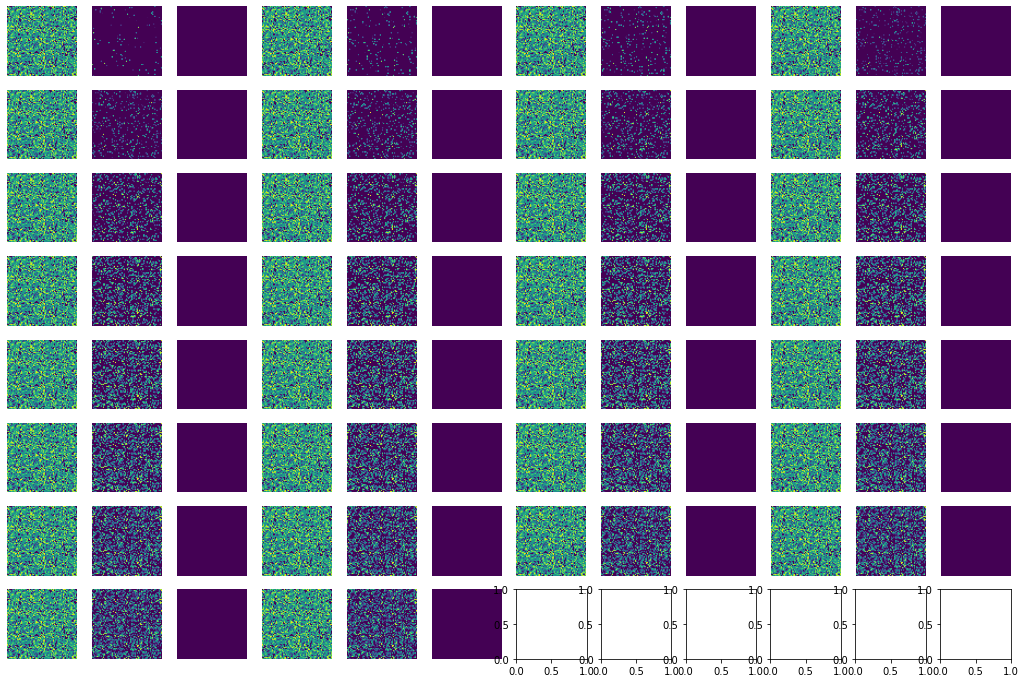

In [ ]:
layer = CriticalLayer0(dict(
        beta=0.5,
        epsilon=0.1,
        alpha=0.005,
        steps_update=100))
a = tf.zeros((1, 64))

a = layer(a)
C_orig = layer.C.numpy()

with jpl.GridPlot(ncols=12, width=18) as grid_plot:
    for _ in range(30):
        a = layer(a)
        
        grid_plot.imshow(layer.C)
        C_diff = C_orig - layer.C
        grid_plot.imshow(tf.nn.relu(C_diff))
        grid_plot.imshow(tf.nn.relu(-C_diff))

## [Criticality meets learning: Criticality signatures in a self-organizing recurrent neural network](https://journals.plos.org/plosone/article?id=10.1371/journal.pone.0178683)

The self-organizing recurrent network (SORN) consists of excitatory $x\in\mathbb{R}^{N_E}$ and inhibitory $y\in\mathbb{R}^{N_I}$ neurons ($N_I = 0.2 \times N_E$) connected in a system of boolean update equations with fast and slow acting responses

- excitatory to excitatory connections $W^{EE} \in \mathbb{R}^{N_E \times N_E}$; $w^{EE}_{ij} \sim \mathcal{B}(p=0.1)\mathcal{U}(0, s^2=0.1)$ without self-connections $w^{EE}_{ij}=0 \Leftrightarrow i=j$
- inhibitory to excitatory connections $W^{EI} \in \mathbb{R}^{N_E \times N_I}$; $w^{EI}_{ij} \sim \mathcal{B}(p=0.2)\mathcal{U}(0, s^2=0.1)$ without self-connections $w^{EI}_{ij}=0 \Leftrightarrow i=j$
- excitatory to inhibitory connections $W^{IE} \in \mathbb{R}^{N_I \times N_E}$; $w^{IE}_{ij} \sim \mathcal{U}(0, s^2=0.1)$ without self-connections $w^{IE}_{ij}=0 \Leftrightarrow i=j$
- input noise $\zeta^{E/I} \sim \mathcal{N}(\mu=0, \sigma^2=0.05)$
- external input $u^{ext}(t) = 0\ \mathrm{(default)}$
- excitatory and inhibitory activation thresholds $T^{E/I} \in \mathbb{R}^{N_E/N_I}$; $T^E \sim \mathcal{U}(0, T^E_{max}=0.5)$, $T^I \sim \mathcal{U}(0, T^I_{max}=1.0)$

In [409]:
#@title architecture params

architecture_params = dict(
    N_E = 200,
    N_I = int(0.2 * 200),
)

### Fast Dynamics

In [410]:
#@title init fast dynamics params
def heaveside_step_fn(x):
    return tf.cast(x > 0, tf.float32)

fast_params = dict(
    activation_fn = heaveside_step_fn,
    T_E_max = 0.5,
    T_I_max = 1.0,
    constant_T_E = None,
    constant_T_I = None,
    zeta_E_mu = 0.0,
    zeta_E_s2 = 0.05,
    zeta_I_mu = 0.0,
    zeta_I_s2 = 0.05,
    W_EE_p = 0.1,
    W_EE_s2 = 0.1,
    W_EI_p = 0.2,
    W_EI_s2 = 0.1,
    W_IE_p = 1.0,
    W_IE_s2 = 0.1,
    u_ext = 0,
)

def init_fast_params(p):

    if 'N_I' not in p:
        p['N_I'] = 0.2 * p['N_E']
    N_E, N_I = p['N_E'], p['N_I']

    p.update(dict(
        T_E = p['constant_T_E'] if p['constant_T_E'] else 
                tf.random.uniform(shape=(N_E, 1), minval=0, 
                                  maxval=p['T_E_max']),
        T_I = p['constant_T_I'] if p['constant_T_I'] else 
                tf.random.uniform(shape=(N_I, 1), minval=0, 
                                  maxval=p['T_I_max']),
        W_EE = Bernoulli(p=p['W_EE_p'], shape=(N_E, N_E)) 
               * tf.random.normal(shape=(N_E, N_E), mean=0.0, 
                                  stddev=p['W_EE_s2'] ** 0.5),
        W_EI = Bernoulli(p=p['W_EI_p'], shape=(N_E, N_I)) 
               * tf.random.normal(shape=(N_E, N_I), mean=0.0, 
                                  stddev=p['W_EI_s2'] ** 0.5),
        W_IE = Bernoulli(p=p['W_IE_p'], shape=(N_I, N_E)) 
               * tf.random.normal(shape=(N_I, N_E), mean=0.0, 
                                  stddev=p['W_IE_s2'] ** 0.5),
        x = tf.zeros((N_E, 1)),
        y = tf.zeros((N_I, 1)),
        x_prev = tf.zeros((N_E, 1)),
        y_prev = tf.zeros((N_I, 1)),
    ))

    return p

Fast-acting behavior affects both excitatory $x$ and inhibitory $y$ neurons by

$$x(t+1) = \Theta \biggl [ W^{EE}(t)x(t) - W^{EI}(t)y(t) + u^{ext}(t) + \xi^E(t) - T^E(t) \biggr ]$$

$$y(t+1) = \Theta \biggl [ W^{IE}(t)x(t) + \xi^I(t) - T^I(t) \biggr ]$$

In [411]:
def fast_update(p):

    p['x_prev'] = p['x']
    p['y_prev'] = p['y']

    zeta_E = tf.random.normal(shape=(p['N_E'], 1),
                              mean=p['zeta_E_mu'],
                              stddev=p['zeta_E_s2'] ** 0.5)
    zeta_I = tf.random.normal(shape=(p['N_I'], 1), 
                              mean=p['zeta_I_mu'],
                              stddev=p['zeta_I_s2'] ** 0.5)
    
    p['x'] = p['activation_fn'](p['W_EE'] @ p['x_prev']
                                - p['W_EI'] @ p['y_prev'] 
                                + p['u_ext'][:, None] 
                                + zeta_E
                                - p['T_E'])
    p['y'] = p['activation_fn'](p['W_IE'] @ p['x_prev'] 
                                + zeta_I 
                                - p['T_I'])

    return p

### Slow Adaptations

In [412]:
#@title init slow adaptation params
#@markdown "Assuming one time step equals 10 to 20 ms, these constants resulted in an average firing rate in the 5 − 10 Hz range." (Papa 2017)
slow_params = dict(
    eta_STDP = 0.004,
    eta_inh = 0.001,
    eta_SP = 0.001,
    p_SP_0 = 0.1,
    mu_IP = 0.1,
    s2_IP = 0.0, # "for simplicity, it could be set to the network average 
                 #  firing rate μIP, thus being equal for all neurons"
    eta_IP = 0.01,
)

def init_slow_params(p):
    
    p.update(dict(
        H_IP = tf.random.normal(shape=(p['N_E'],), 
                                mean=p['mu_IP'],
                                stddev=p['s2_IP']),
        p_SP = (p['N_E']*((p['N_E']-1)) / 
                (200*(200-1))) * p['p_SP_0'],
    ))
    del p['p_SP_0']

    return p

1. **Spike Timing Dependant Plasticity (STDP)** makes synapse $w^{EE}_{ij}$ decrease when $i$ activates before $j$ (since the connection must've not been important) and increase when $i$ activate after $j$ (since the connection made a significant contribution). It has no effect when one of the values is $0$: $$\Delta w^{EE}_{ij} = \eta_{STDP}[x_i(t)x_j(t-1) - x_j(t)x_i(t-1)]$$

In [413]:
def STDP(p):

    p['W_EE'] = p['W_EE'] + p['eta_STDP'] * (
                    p['x'] * tf.transpose(p['x_prev'])
                    -tf.transpose(p['x']) * p['x_prev'])
    
    return p

2. **Inhibitory Spike Timing Dependant Plasticity (iSTDP)** increases (decreases) the strength of *existing ($w^{EI}_{ij}>0$)* inhibitory to excitatory connections when they are unsucessful (sucessful) at inhibiting their downstream excitatory neurons. Inhibitory synaptic growth is (target firing rate $\mu_{IP}$ times) slower to strengthen synapses than weaken them: $$\begin{align*}
\Delta w^{EI}_{ij} =& \frac{\eta_{inh}}{\mu_{IP}}x_i(t)y_j(t-1) - \eta_{inh}(1-x_i(t))y_j(t-1) \\
 =& -\eta_{inh}y_j(t-1)[1-x_i(t)(1+1/\mu_{IP})] \end{align*}$$

In [414]:
def iSTDP(p):

    p['W_EI'] = p['W_EI'] + p['eta_inh'] * tf.transpose(p['y_prev']) * \
                    (1 - p['x'] * (1 + 1/p['mu_IP']))

    return p

3. **Synaptic normalization** normalizes input for $W^{EE}$ and $W^{EI}$ to $1$: $$W^{EE/EI}_{ij} \leftarrow W^{EE/EI}_{ij} / \sum_j W^{EE/EI}_{ij}$$

In [479]:
def synaptic_normalization(p):

    p['W_EE'] = p['W_EE'] / (tf.reduce_sum(p['W_EE'], axis=-1, keepdims=True) + 1e-3)
    p['W_EI'] = p['W_EI'] / (tf.reduce_sum(p['W_EI'], axis=-1, keepdims=True) + 1e-3)

    return p

4. **Structural Plasticity (SP)** randomly adds small values synapses ($\eta_{SP}=0.001$) between unconnected neurons by Bernoili probability factor $p_{SP}$ which scales quatratically with respect to the number of nodes $p_{SP}(N^E) = \frac{N^E(N^E-1)}{200(199)}p_{SP}(N^E=200)$ with the base case $p_{SP}(N^E=200) = 0.1$. $$w^{EE/EI}_{ij} \leftarrow \eta_{SP}\mathcal{B}(p_{SP}) \Leftrightarrow w^{EE/EI}_{ij} = 0$$

In [416]:
def structural_plasticity(p):
    
    no_W_EE_synapses_mask = tf.cast(p['W_EE'] == 0, tf.float32)
    new_W_EE_synapses = p['eta_SP'] * Bernoulli(p['p_SP'], shape=p['W_EE'].shape)
    p['W_EE'] = p['W_EE'] + no_W_EE_synapses_mask * new_W_EE_synapses 

    no_W_EI_synapses_mask = tf.cast(p['W_EI'] == 0, tf.float32)
    new_W_EI_synapses = p['eta_SP'] * Bernoulli(p['p_SP'], shape=p['W_EI'].shape)
    p['W_EI'] = p['W_EI'] + no_W_EI_synapses_mask * new_W_EI_synapses 

    return p


5. **Intrinsic plasticity (IP)** homeostatically adapts excitatory firing thresholds to maintain a mean firing rate $H_{IP} \sim \mathcal{N}(\mu_{IP}=0.1, \sigma_{IP}^2 = 0)$ $$\Delta T^{E} = \eta_{IP}[x(t) - H_{IP}]$$

In [417]:
def intrinsic_plasticity(p):

    p['T_E'] = p['T_E'] + p['eta_IP'] * (p['x'] - p['H_IP'][:, None])

    return p

Negative ($x<0$), large ($x>1$), and null weights are pruned after each update step. Also remove any self connections that may have been formed

In [480]:
def slow_adaptation(p):

    p = STDP(p)
    p = iSTDP(p)
    p = synaptic_normalization(p)
    p = structural_plasticity(p)
    p = intrinsic_plasticity(p)

    p['W_EE'] = tf.clip_by_value(p['W_EE'], 0.0, 1.0)
    p['W_EI'] = tf.clip_by_value(p['W_EI'], 0.0, 1.0)
    p['W_IE'] = tf.clip_by_value(p['W_IE'], 0.0, 1.0)

    p['W_EE'] = clear_diag(p['W_EE'])
    p['W_EI'] = clear_diag(p['W_EI'])
    p['W_IE'] = clear_diag(p['W_IE'])

    return p

### Putting it all together

In [481]:
class SORN:

    DEFAULT_ARCHITECTURE_PARAMS = architecture_params
    DEFAULT_FAST_PARAMS = fast_params
    DEFAULT_SLOW_PARAMS = slow_params

    def __init__(self, params=None):

        self.params = dict()
        self.params.update(SORN.DEFAULT_ARCHITECTURE_PARAMS)
        self.params.update(SORN.DEFAULT_FAST_PARAMS)
        self.params.update(SORN.DEFAULT_SLOW_PARAMS)
        if params: 
            self.params.update(params)
        self.params = init_fast_params(self.params)
        self.params = init_slow_params(self.params)


    def __call__(self, inputs=None, T=None, logging_fn=None):
        """simulate SORN on an external input tensor shaped (T, N_E)
        or zero external input for T timesteps."""

        if inputs is None and T is not None:
            inputs = tf.zeros((T, self.params['N_E']))

        for input in tf.unstack(inputs, axis=0):
            self.params['u_ext'] = input
            self.params = fast_update(self.params)
            self.params = slow_adaptation(self.params)

            if logging_fn:
                logging_fn(self.params)

### Experiments

In [420]:
#@title plotting utilities

class Logger:

    def __init__(self, T, N_E, N_I):
        self.xs = tf.zeros((1, N_E))
        self.ys = tf.zeros((1, N_I))
        self.W_EEs = tf.zeros((1, N_E, N_E))
        self.W_EIs = tf.zeros((1, N_E, N_I))
        self.W_IEs = tf.zeros((1, N_I, N_E))


    def logging_fn(self, params):
        self.xs = tf.concat([self.xs, params['x'][None, ..., 0]], axis=0)
        self.ys = tf.concat([self.ys, params['y'][None, ..., 0]], axis=0)
        self.W_EEs = tf.concat([self.W_EEs, params['W_EE'][None, ...]], axis=0)
        self.W_EIs = tf.concat([self.W_EIs, params['W_EI'][None, ...]], axis=0)
        self.W_IEs = tf.concat([self.W_IEs, params['W_IE'][None, ...]], axis=0)

#### Playground

I want to try
- sampling a temperature weighted bernoili heaveside instead
- add inhibitory intristic plasticity
- unite excitatory and inhibitory neurons with single equation

##### First test

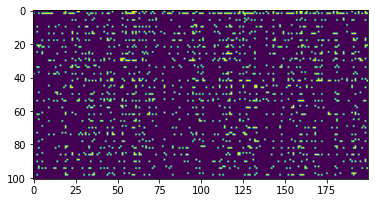

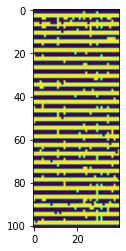

In [424]:
#@title this was with the default parameters
plt.imshow(logger.xs)
plt.show()
plt.imshow(logger.ys)
plt.show()

#### Long test

In [ ]:
N_E = 200
N_I = 40
T = 10000

logger = Logger(T, N_E, N_I)

SORN(dict(N_E=N_E, N_I=N_I))(T=T, logging_fn=logger.logging_fn)

In [430]:
logger.xs.shape

TensorShape([4634, 200])

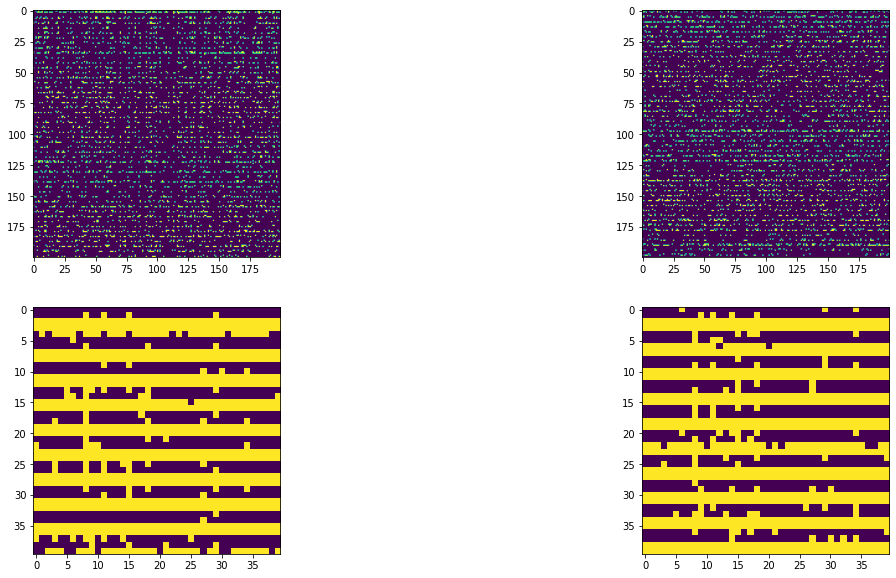

In [441]:
fig, ((axes00, axes01), 
      (axes10, axes11)) = plt.subplots(nrows=2, ncols=2, 
                                       figsize=(20,10))
axes00.imshow(logger.xs[:200, ...])
axes01.imshow(logger.xs[-200:, ...])
axes10.imshow(logger.ys[:40, ...])
axes11.imshow(logger.ys[-40:, ...])
fig.show()

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


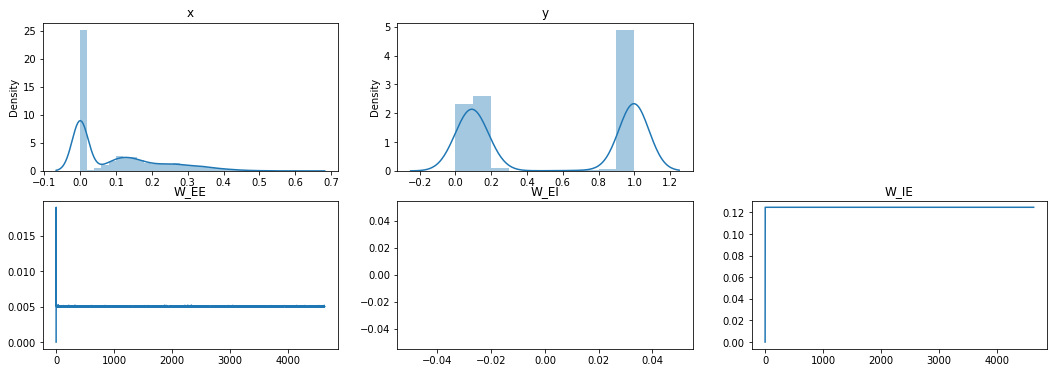

In [475]:
plt.figure(figsize=(18, 6))
plt.title("Means over time")

ax = plt.subplot("231")
ax.set_title("x")
sns.distplot(tf.reduce_mean(logger.xs, axis=-1), ax=ax)

ax = plt.subplot("232")
ax.set_title("y")
sns.distplot(tf.reduce_mean(logger.ys, axis=-1), ax=ax)

ax = plt.subplot("234")
ax.set_title("W_EE")
ax.plot(tf.reduce_mean(logger.W_EEs, axis=[1, 2]))

ax = plt.subplot("235")
ax.set_title("W_EI")
ax.plot(tf.reduce_mean(logger.W_EIs, axis=[1, 2]))

ax = plt.subplot("236")
ax.set_title("W_IE")
ax.plot(tf.reduce_mean(logger.W_IEs, axis=[1, 2]))

plt.show()

In [478]:
tf.debugging.assert_all_finite(logger.W_EIs, 'not')

InvalidArgumentError: ignored

#### Fixed numerical stability problem

In [483]:
N_E = 200
N_I = 40
T = 1000

logger = Logger(T, N_E, N_I)

SORN(dict(N_E=N_E, N_I=N_I))(T=T, logging_fn=logger.logging_fn)

In [489]:
tf.debugging.assert_all_finite(logger.W_EEs, 'NaN')
tf.debugging.assert_all_finite(logger.W_EIs, 'NaN')
tf.debugging.assert_all_finite(logger.W_IEs, 'NaN')

logger.xs.shape

TensorShape([1001, 200])

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


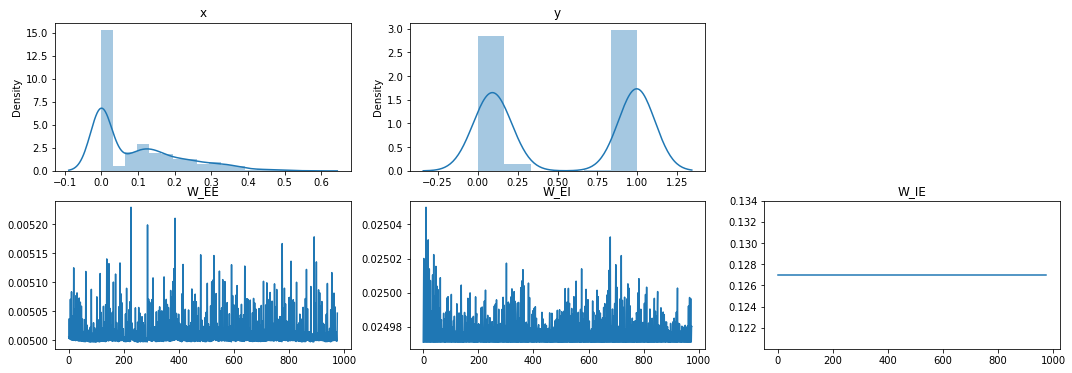

In [491]:
plt.figure(figsize=(18, 6))
plt.title("Means over time")

ax = plt.subplot("231")
ax.set_title("x")
sns.distplot(tf.reduce_mean(logger.xs, axis=-1), ax=ax)

ax = plt.subplot("232")
ax.set_title("y")
sns.distplot(tf.reduce_mean(logger.ys, axis=-1), ax=ax)

ax = plt.subplot("234")
ax.set_title("W_EE")
ax.plot(tf.reduce_mean(logger.W_EEs[25:, ...], axis=[1, 2]))

ax = plt.subplot("235")
ax.set_title("W_EI")
ax.plot(tf.reduce_mean(logger.W_EIs[25:, ...], axis=[1, 2]))

ax = plt.subplot("236")
ax.set_title("W_IE")
ax.plot(tf.reduce_mean(logger.W_IEs[25:, ...], axis=[1, 2]))

plt.show()

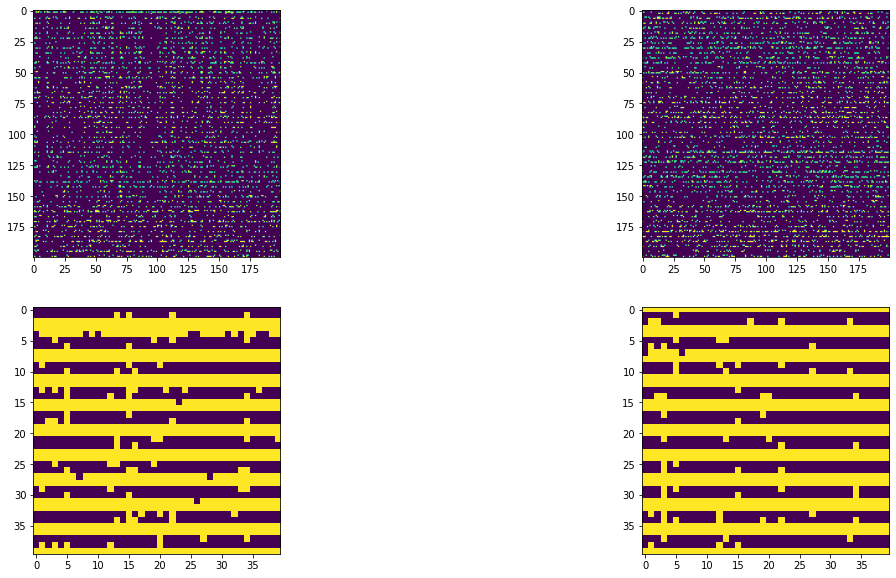

In [492]:
fig, ((axes00, axes01), 
      (axes10, axes11)) = plt.subplots(nrows=2, ncols=2, 
                                       figsize=(20,10))
axes00.imshow(logger.xs[:200, ...])
axes01.imshow(logger.xs[-200:, ...])
axes10.imshow(logger.ys[:40, ...])
axes11.imshow(logger.ys[-40:, ...])
fig.show()

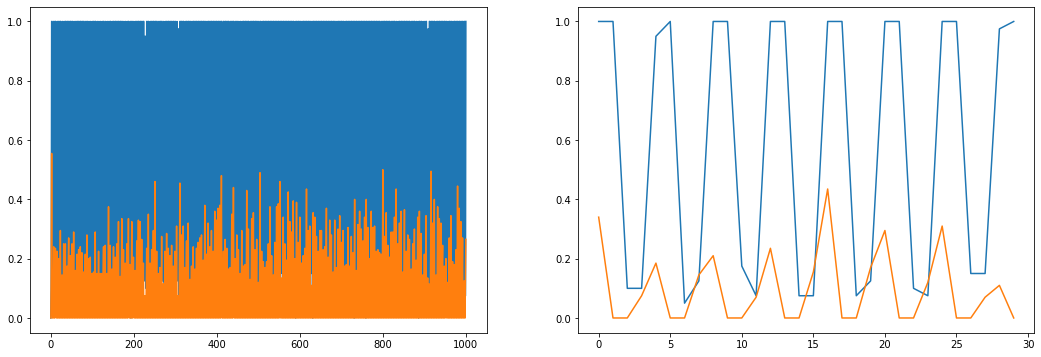

In [503]:
plt.figure(figsize=(18, 6))

ax = plt.subplot("121")
ax.plot(tf.reduce_mean(logger.xs, axis=-1))
ax.plot(tf.reduce_mean(logger.ys, axis=-1))

ax = plt.subplot("122")
ax.plot(tf.reduce_mean(logger.xs[600:630], axis=-1))
ax.plot(tf.reduce_mean(logger.ys[600:630], axis=-1))

##### Testing for power laws

In [505]:
!pip install powerlaw
import powerlaw

  Created wheel for powerlaw: filename=powerlaw-1.4.6-cp37-none-any.whl size=24787 sha256=d4b7e910bec8fe0a4f07b4078111c51115f4fb5e353b7549ded25480e8f405ff
  Stored in directory: /root/.cache/pip/wheels/e0/27/02/08d0e2865072bfd8d7c655e290521e3feca3fc22f1ac460601
Successfully built powerlaw


In [506]:
xs_mean = tf.reduce_mean(logger.xs, axis=-1)

Values less than or equal to 0 in data. Throwing out 0 or negative values
Calculating best minimal value for power law fit
/usr/local/lib/python3.7/dist-packages/powerlaw.py:700: RuntimeWarning: invalid value encountered in true_divide
  (Theoretical_CDF * (1 - Theoretical_CDF))


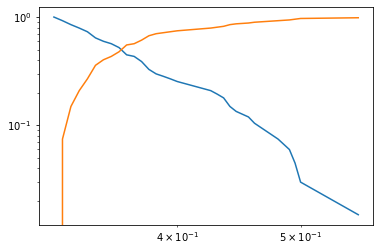

In [517]:
fit = powerlaw.Fit(xs_mean) #([1,3,5,6,3,2,4,7,4,5,21,3,14,24,243,2,2,4,1,11,3,3,5,6])
fit.plot_ccdf()
fit.plot_cdf()

#### No Input

#### Random Input

#### Structured Input

### Notes

#### Is learning maximized when internal dynamics are already at the edge of criticality?

**Background** Intelligence is a scarse resource and must be utilized effectively to maximize growth. Intrinsically motivated learning can only select a subset of information from the environment to send through the bottleneck of interaction. However the human's subjective measure of information is not equal to information theory's negative log likelihood. Instead the brain acquires maximum information about its environment from stimuli that are neither overly boring nor excessively surprising. Rather, it is critical information which varies in-between either extreme that maximally attracts attention. For example, my intrinsic motivation to learn gravitates toward material somewhere in-between the high-school and post-docoral levels.

(Del Papa et al. 2017) confirmed structured input *temporarily* breaks down critical dynamics. However, power laws reliably return after a period of readaptation.  

**Observations**

**Conclusion**

## SORN + Average normalization